In [1]:
from general_utils import *
from model_utils import *
from losses import *
from models import *

# Get configs
with open(config_file_path, "r") as file:
    configs = json.load(file)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [17]:
class Time_Invariant_Survival:
    '''
    Class for fitting, testing, evaluating and explaining survival distributions
    '''
    def __init__(self, configs, train_data, test_data, val_data):
        '''
        configs - dictionary created from loaded json file that contains all configs parsed from config file
        train_data - self.explanatory
        test_data - self.explanatory
        val_data - self.explanatory
        '''
        self.configs = configs
        # assumes that last two columns contain survival time and survival status
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data

        # state vars
        self.clustered = False
        self.fitted = False
        self.discretized = False
        self.predicted = False
        
        # read from config file
        self._clusters = self.configs['time_invariant']['training']['clusters'] # Specify the number of clusters (K)
        self.q_cuts = self.configs['time_invariant']['training']['q_cuts']    # number of discretized durations
        self.hidden_size = self.configs['time_invariant']['training']['hidden_size'] # hidden size of MLP
        self.output_size = self.q_cuts # same as discretizations
        self.alpha = self.configs['time_invariant']['training']['alpha'] # trade off between two loss functions
        self.batch_size = self.configs['time_invariant']['training']['batch_size'] # batch size for NN
        self.num_epochs = self.configs['time_invariant']['training']['num_epochs'] # Number of epochs for NN
        self.learning_rate = self.configs['time_invariant']['training']['learning_rate'] # LR for NN
        self.shuffle = self.configs['time_invariant']['training']['shuffle'] # shuffle for Dataloader class
        self.patience = self.configs['time_invariant']['training']['patience'] # patience for early stopping
        self.dropout = self.configs['time_invariant']['training']['dropout'] # dropout for training and MC dropout    
        
    def cluster_train(self):
        '''
        cluster the training data
        '''
        # Create a KMeans instance and fit the data
        self.kmeans = KMeans(n_clusters=self._clusters , n_init = 'auto')
        self.kmeans.fit(self.train_data.iloc[: , :-2])

        # Add cluster
        self.train_data['cluster'] = self.kmeans.labels_

        # grouping based on cluster
        train_grouped = self.train_data.groupby('cluster')

        # drop cluster to avoid shape problems - no need to make this an object attr
        self.train_data.drop('cluster' , axis = 1 , inplace = True)

        # test
        assert self.train_data.shape[1] == self.val_data.shape[1] == self.test_data.shape[1]

        # change state
        self.clustered = True

        return train_grouped

    def cluster_other(self , _data):
        '''
        uses the fitted kmeans object
        _data: can be test or validation data
        '''
        if not self.clustered:
            raise Exception("Clustering is not done yet!")

        # Test_____________________________________________________________
        _clusters = self.kmeans.predict(_data.iloc[: , :-2])
        
        # Add cluster
        _data['cluster'] = _clusters

        _grouped = _data.groupby('cluster')

        # drop cluster to avoid shape problems
        _data.drop('cluster' , axis = 1 , inplace = True)

        return _grouped

    def fit(self):
        '''
        fitter function
        '''
        input_size = self.train_data.iloc[: , :-2].shape[1]

        # build net(s)
        self.nets = []
        
        # init loss
        l = generic_Loss()

        # init besst loss for early stopping
        best_loss = np.Inf

        # get clusters
        x_train_grouped = self.cluster_train() #train
        x_val_grouped = self.cluster_other(self.val_data) #val

        # init as many networks as there are clusters
        for grp in x_train_grouped.groups.keys():
            # init net
            mlp = MLP(input_size , self.hidden_size , self.output_size , self.dropout)
            
            # init optim
            optimizer = torch.optim.Adam(mlp.parameters() , lr = self.learning_rate)

            # append
            self.nets.append((mlp , optimizer))

        for i , grp in enumerate(x_train_grouped.groups.keys()): 
            print(f'training cluster {i}')
            
            # get features, death time and event indicator
            features = x_train_grouped.get_group(grp)
            
            y_train_dur , y_train_event = get_target(features)

            t_train = Transforms(durations = y_train_dur)
            dur_idx = t_train.discrete_transform(_cuts = self.q_cuts)

            features = features.iloc[: , :-2].to_numpy() # curtail  features column

            # Create an instance of your custom dataset
            dataset = MyDataset(features, dur_idx , y_train_dur , y_train_event) # need to change outcomes[0] to indexed version
            dataloader = DataLoader(dataset, batch_size = self.batch_size, shuffle = self.shuffle)
            
            # get mlp and optimizer
            net = self.nets[i][0]
            optimizer = self.nets[i][1]

            # Training loop
            for epoch in range(self.num_epochs):
                for batch_id , (patient_image , dur_idx , dur , eve) in enumerate(dataloader):

                    # Prime for training
                    net.train()
                    
                    # forward pass
                    phi_train = net(patient_image)

                    # make survival matrix
                    sm = Surv_Matrix(duration_index = dur_idx, events = eve , q_cuts = self.q_cuts)
                    surv_mat = sm.make_survival_matrix()        

                    # get loss
                    loss_1 = l.nll_logistic_hazard(
                        logits = phi_train , 
                        targets = surv_mat , 
                        dur_idx = dur_idx
                        )
                    loss_2 = l.c_index_lbo_loss(
                        logits = phi_train , 
                        times = dur , 
                        events = eve
                        )
                    
                    # combine
                    loss = self.alpha*loss_1 + (1-self.alpha)*(loss_2)

                    # backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    # Early stopping
                    with torch.no_grad():
                        # get features, death time and event indicator
                        val_features = x_val_grouped.get_group(grp)
                        
                        y_val_dur , y_val_event = get_target(val_features)

                        t_val = Transforms(durations = y_val_dur)
                        dur_idx_val = t_val.discrete_transform(_cuts = self.q_cuts)

                        val_features = val_features.iloc[: , :-2].to_numpy() # curtail  features column
                        
                        # prepare validation data with survival matrix (reqd for L1 (NLL Loss))
                        sm_val = Surv_Matrix(duration_index = dur_idx_val , events = y_val_event , q_cuts = self.q_cuts)
                        surv_mat_val = sm_val.make_survival_matrix()  
                            
                        # pass through the net
                        phi_val = net(val_features)
                        val_loss_1 = l.nll_logistic_hazard(
                            logits = phi_val, 
                            targets = surv_mat_val , 
                            dur_idx = dur_idx_val
                            )
                        val_loss_2 = l.c_index_lbo_loss(
                            logits = phi_val , 
                            times = torch.Tensor(y_val_dur) , 
                            events = torch.Tensor(y_val_event)
                            )

                        # combine
                        val_loss = self.alpha*val_loss_1 + (1-self.alpha)*(val_loss_2)

                    # Check if validation loss has improved
                    if val_loss < best_loss:
                        best_loss = val_loss
                        counter = 0
                    else:
                        counter += 1

                    # Check if early stopping condition is met
                    if counter >= self.patience:
                        # print(f"Early stopping at epoch {epoch}.")
                        break

                if (epoch%50==0): print(f"Epoch {epoch}: Training Loss: {loss.item():.7f}, Val Loss: {val_loss.item():.7f}") 
        
        # change state
        self.fitted = True

    def predict(self):
        '''
        this is the prediction suite
        '''       
        if not self.fitted:
            raise Exception("Model isn't fitted yet!")

        x_test_grouped = self.cluster_other(self.test_data)

        # Testing
        surv = [] # length will be equal to number of cluster
        mc_iter = self.configs['time_invariant']['testing']['mc_iter']
        conf_int_lower = self.configs['time_invariant']['testing']['conf_int_lower']
        conf_int_upper = self.configs['time_invariant']['testing']['conf_int_upper']
        

        # init empty lists for duration and event 
        y_test_dur = []
        y_test_event = []

        # predict for each cluster
        for i , grp in enumerate(x_test_grouped.groups.keys()):
            
            # get features, death time and event indicator
            features = x_test_grouped.get_group(grp)

            # get death time and event indicator
            y_test_dur_ , y_test_event_ = get_target(features)

            # add to lists (useful for mc iterations)
            y_test_dur.append(y_test_dur_)
            y_test_event.append(y_test_event_)

            # curtail features matrix
            features = features.iloc[: , :-2].to_numpy()

            survival = []

            # apply Monte Carlo dropout
            for _ in range(mc_iter):
                net = self.nets[i][0]
                
                # Prime dropout layers
                net.train()
                
                # predict
                mc_haz = torch.sigmoid(net(features))
                mc_survival = torch.cumprod(1 - mc_haz , dim = 1).detach().numpy()

                # append survivals from different runs
                survival.append(mc_survival)
            
            # convert to 3d array
            survival = np.array(survival)
            
            surv.append(survival)

        # Concatenate durations and event indicators
        y_test_dur = np.concatenate(y_test_dur , axis = 0)
        y_test_event = np.concatenate(y_test_event , axis = 0)

        # QCs
        assert len(surv) == self._clusters , 'surv matrix not matching number of clusters'
        assert len(x_test) == np.sum([surv[k].shape[1] for k in range(self._clusters)]) , 'test set count mismatch'

        mean_ = np.concatenate([surv[k].mean(axis = 0) for k in range(self._clusters)])
        up_ = np.concatenate([np.quantile(surv[k] , axis = 0 , q = conf_int_upper) for k in range(self._clusters)])
        low_ = np.concatenate([np.quantile(surv[k] , axis = 0 , q = conf_int_lower) for k in range(self._clusters)])
        
        # QCs
        assert mean_.shape[0] == up_.shape[0] == low_.shape[0] == y_test_dur.shape[0] == y_test_event.shape[0] , 'shape mismatch'

        # change
        self.predicted = True
        
        return mean_ , up_ , low_ , y_test_dur , y_test_event

    def visualize(self , mean_ , low_ , up_ , _from , _to):
        '''
        visualize the predictions
        '''
        # get features, death time and event indicator
        features = self.test_data

        # get death time and event indicator
        y_test_dur_ , y_test_event_ = get_target(features)

        t_test = Transforms(durations = y_test_dur_)
        dur_idx_test = t_test.discrete_transform(_cuts = self.q_cuts)

        # get transparency for graph
        transparency = self.configs['time_invariant']['test_viz']['transparency']
        _ = plot_with_cf(t_test.bin_edges, mean_ , low_ , up_ , _from , _to , transparency = transparency)

    def evaluation(self , mean_ , y_test_dur , y_test_event):
        '''
        Evaluation by
        1. td c-index
        2. Brier score
        3. IBS
        '''
        # Evaluation
        ev_ = EvalSurv(pd.DataFrame(mean_.T) , y_test_dur , y_test_event , censor_surv='km')
        
        # brier score
        time_grid_div = self.configs['time_invariant']['eval']['time_grid_div']
        time_grid = np.linspace(y_test_dur.min(), y_test_dur.max(), time_grid_div)
        ev_.brier_score(time_grid).plot()
        plt.ylabel('Brier score')
        _ = plt.xlabel('Time')

        # td c-index
        tdci = ev_.concordance_td()
        # print(f'concordance-td: {tdci}')
        
        # IBS
        ibs = ev_.integrated_brier_score(time_grid)
        # print(f'integrated brier score {ibs}')
        
        return tdci , ibs


In [18]:
# Read the pickled DataFrames
with open('../05_preprocessing_emr_data/data/x_train.pickle', 'rb') as file:
    x_train = pickle.load(file)
with open('../05_preprocessing_emr_data/data/x_test.pickle', 'rb') as file:
    x_test = pickle.load(file)
with open('../05_preprocessing_emr_data/data/x_val.pickle', 'rb') as file:
    x_val = pickle.load(file)

# Read the pickled DataFrame
with open('../05_preprocessing_emr_data/data/consolidated_pat_tbl.pickle', 'rb') as file:
    consolidated_pat_tbl = pickle.load(file)

In [19]:
obj = Time_Invariant_Survival(
    configs = configs, 
    train_data = x_train,
    test_data = x_test, 
    val_data = x_val
    )

training cluster 0
Epoch 0: Training Loss: 0.0283818, Val Loss: 0.0296150
Epoch 50: Training Loss: 0.0066668, Val Loss: 0.0088316
Epoch 100: Training Loss: 0.0057067, Val Loss: 0.0065296
Epoch 150: Training Loss: 0.0055788, Val Loss: 0.0055003
Epoch 200: Training Loss: 0.0081112, Val Loss: 0.0046335
Epoch 250: Training Loss: -0.0003464, Val Loss: 0.0045960
Epoch 300: Training Loss: 0.0053921, Val Loss: 0.0042705
Epoch 350: Training Loss: 0.0017124, Val Loss: 0.0045744
Epoch 400: Training Loss: 0.0056596, Val Loss: 0.0045574
Epoch 450: Training Loss: 0.0034940, Val Loss: 0.0041095
CPU times: total: 4min 9s
Wall time: 40.2 s


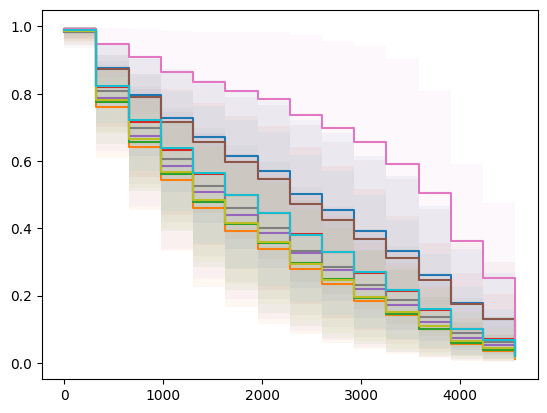

In [20]:
%%time

obj.fit()
mean_ , up_ , low_ , y_test_dur , y_test_event = obj.predict()
obj.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )

shapes : (1060, 1060, 1060, 1060)
concordance-td: 0.6945233533725309
integrated brier score 0.4074179147081617


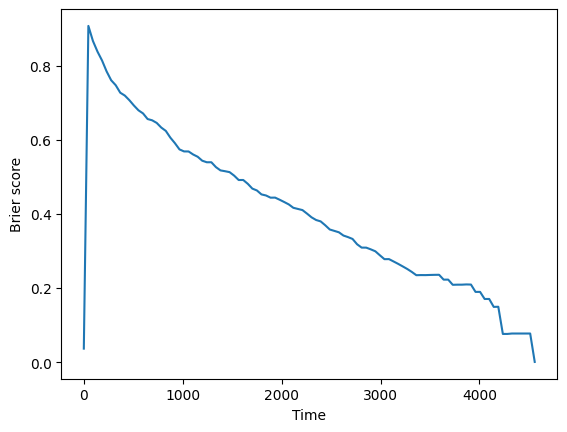

In [21]:
cindex , ibs = obj.evaluation(mean_ , y_test_dur , y_test_event)

-------------

In [7]:

    # def discretize_test(self):
    #     '''
    #     function to discretize test and validation survival times
    #     '''     
    #     # Prepare val and test data
    #     get_target = lambda df: (df['time_to_event'].values, df['death'].values)
        
    #     self.y_test_dur , self.y_test_event = get_target(self.test_data)
    #     # self.y_val_dur , self.y_val_event = get_target(self.val_data)

    #     t_test = Transforms(durations = self.y_test_dur)
    #     self.dur_idx_test = t_test.discrete_transform(_cuts = self.q_cuts)

    #     # t_val = Transforms(durations = self.y_val_dur)
    #     # self.dur_idx_val = t_val.discrete_transform(_cuts = self.q_cuts)

    #     # # prepare validation data with survival matrix (reqd for L1 (NLL Loss))
    #     # sm_val = Surv_Matrix(duration_index = self.dur_idx_val , events = self.y_val_event , q_cuts = self.q_cuts)
    #     # self.surv_mat_val = sm_val.make_survival_matrix()

    #     # change state
    #     self.discretized = True
